In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import re
import string
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

2023-07-03 15:15:16.632584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(42)

In [3]:
# import os
# os.environ['WANDB_MODE'] = 'offline'


### Load dataset

In [4]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
"Running in colab" if IN_COLAB else "Running locally"

'Running locally'

### Init wandb

In [5]:
if IN_COLAB:
  !pip install wandb -q
  !pip install python-dotenv -q
  !pip install ruamel.yaml -q

import wandb

from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
   WandbCallback,
)
from ruamel.yaml import YAML

In [6]:
import os
from dotenv import load_dotenv; load_dotenv("wandb.env")
os.environ["WANDB_NOTEBOOK_NAME"] = "translate_train_debug.ipynb"
wandb.login()

wandb: Currently logged in as: amirfvb. Use `wandb login --relogin` to force relogin


True

In [7]:
yaml=YAML(typ='safe')
with open('trans_params_debug.yaml', 'r') as file:
    config_file = yaml.load(file)

wandb.init(
    # set the wandb project where this run will be logged
    project="CRNN_translate_debug",

    # name="test_determinism",
    # notes="Removed gradient clipping",
    config=config_file,
    save_code=True,
)
# wandb.run.log_code(include_fn=lambda path: path.endswith("translate_train.ipynb"))
wandb.run.log_code(include_fn=lambda path: path.endswith(".ipynb") or path.endswith(".py"))
config = wandb.config

In [8]:
UNITS = config["hidden_dims"]
input_dim = config["input_size"]

### Dataset loading

In [9]:
if IN_COLAB:
    # download dataset

    import pathlib

    path_to_zip = tf.keras.utils.get_file(
        'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
        extract=True)

    path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

    def load_data(path):
        text = path.read_text(encoding='utf-8')

        lines = text.splitlines()
        pairs = [line.split('\t') for line in lines]

        context = np.array([context for target, context in pairs])
        target = np.array([target for target, context in pairs])

        return target, context

    target_raw, context_raw = load_data(path_to_file)

    print(context_raw[-1])
    print(target_raw[-1])

else:
    df = pd.read_csv("data/spa-eng.zip", delimiter="\t", names=["translate", "source", "attr"])
    context_raw = np.array(df["source"])
    target_raw = np.array(df["translate"])
    print(context_raw[-1])
    print(target_raw[-1])

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8 # todo. Check reproducibility and across methods (colab/not colab)


train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))



Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.
One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.


#### My dataset processing

In [10]:
def custom_standardization(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation + "¿¡"), '')
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
vocab_size = 5000
# sequence_length = 250



context_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', 'de', 'que', 'no', 'tom', 'a', 'la']

In [11]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'i', 'the', 'to', 'you', 'tom', 'a']

#### End of text processings

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [14]:
alpha = 1
def reg_loss(y_true, y_pred):
    m_loss = masked_loss(y_true, y_pred)
    weights = model.decoder.rnn.trainable_weights
    w = weights[0]
    det_reg = tf.math.square(tf.linalg.det(w)-1)
    # Return the total.
    return m_loss + alpha*det_reg

In [15]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### define model

In [16]:
%load_ext autoreload

%autoreload 2

In [17]:
if config["model"] == "crnn":
    # from context_rnn_translate_model import Translator
    # wandb.run.log_code(include_fn=lambda path: path.endswith("attention_gru_translate_model.py"))

    import tensorflow as tf
    from tensorflow.keras import layers

    from tensorflow.linalg import LinearOperatorFullMatrix
    import numpy as np


    class ContextualRNNCell(layers.Layer):
        '''
        n -- latent space dimension
        m -- input size
        '''

        def __init__(self, units, **kwargs):
            super().__init__(**kwargs)
            self.n = units
            self.state_size = [
                tf.TensorShape((self.n, self.n)),
                tf.TensorShape((self.n, self.n)),
                tf.TensorShape((self.n, 1))]
            self.ftype = tf.float32

        def build(self, input_shape):

            self.m = input_shape[-1]
            n, m = self.n, self.m
            self.W = tf.Variable(tf.linalg.eye(*(n+m,)*2, batch_shape=(1,), dtype=self.ftype))  # trainable param

            # trainable dense layers
            self.f = layers.Dense(n, dtype=self.ftype)
            self.g = layers.Dense(m, dtype=self.ftype)

            # constant dense layers
            self.h = layers.Dense(m, dtype=self.ftype)
            self.h.trainable = False
            self.r = layers.Dense(m*m, dtype=self.ftype)
            self.r.trainable = False

            proj_h = np.hstack([np.identity(n), np.zeros((n, m))])  # projector on hidden space (first n coords)
            proj_y = np.hstack([np.zeros((m, n)), np.identity(m)])  # projector measured space (last m coords)
            self.proj_h = tf.convert_to_tensor(proj_h, dtype=self.ftype)
            self.proj_y = tf.convert_to_tensor(proj_y, dtype=self.ftype)

        def call(self, input, states):
            A_prev, J_prev, alpha_prev = states
            x = input

            x = tf.cast(x, self.ftype)
            # alpha = alpha_prev + tf.linalg.inv(A_prev)@tf.expand_dims(self.f(x), 2)
            alpha = alpha_prev + tf.expand_dims(self.f(x), 2)

            beta = tf.expand_dims(self.g(x), 2)
            # K    = self.h(x) # TODO dich kakaia-to
            S = tf.reshape(self.r(x), (-1, self.m, self.m))
            B = S@tf.transpose(S, [0, 2, 1])

            U = tf.linalg.LinearOperatorBlockDiag([LinearOperatorFullMatrix(A_prev),
                                                LinearOperatorFullMatrix(B)]).to_dense()
            gamma = tf.concat([alpha, beta], 1)

            # transform the graph state by performing a Gaussian operation
            U = self.W@U@tf.transpose(self.W, [0, 2, 1])
            w_inv_t = tf.transpose(tf.linalg.inv(self.W), [0, 2, 1])
            gamma = w_inv_t@gamma
            # L = w_inv_t@L

            # read out the lattice and stabilizer phases
            y = self.proj_y@gamma  # Пy@L

            # project out the measured register
            A = self.proj_h@U@tf.transpose(self.proj_h, [1, 0])
            alpha = self.proj_h@gamma
            return y[..., 0], (A, J_prev, alpha)    # TODO replace J_prev with counted new J

        def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
            A = tf.eye(self.n, batch_shape=[batch_size], dtype=self.ftype)
            J = tf.zeros((batch_size, self.n, self.n), dtype=self.ftype)
            alpha = tf.zeros((batch_size, self.n, 1), dtype=self.ftype)

            return A, J, alpha


    def get_rnn_layer(units, **kwargs):
        return layers.RNN(
            ContextualRNNCell(units),
            **kwargs)


    class Encoder(tf.keras.layers.Layer):
        def __init__(self, text_processor, units, input_dim):
            super(Encoder, self).__init__()
            self.text_processor = text_processor
            self.vocab_size = text_processor.vocabulary_size()
            self.units = units

            # The embedding layer converts tokens to vectors
            self.embedding = tf.keras.layers.Embedding(self.vocab_size, input_dim,
                                                    mask_zero=True)

            # The RNN layer processes those vectors sequentially.
            self.rnn = get_rnn_layer(units, return_state=True)

        def call(self, x):
            # 2. The embedding layer looks up the embedding vector for each token.
            x = self.embedding(x)

            # 3. The GRU processes the sequence of embeddings.
            x, *last_state = self.rnn(x)

            return last_state

        def convert_input(self, texts):
            texts = tf.convert_to_tensor(texts)
            if len(texts.shape) == 0:
                texts = tf.convert_to_tensor(texts)[tf.newaxis]
            context = self.text_processor(texts).to_tensor()
            last_state = self(context)
            return last_state


    class Decoder(tf.keras.layers.Layer):

        def __init__(self, text_processor, units):
            super(Decoder, self).__init__()
            self.text_processor = text_processor
            self.vocab_size = text_processor.vocabulary_size()
            self.word_to_id = tf.keras.layers.StringLookup(
                vocabulary=text_processor.get_vocabulary(),
                mask_token='', oov_token='[UNK]')
            self.id_to_word = tf.keras.layers.StringLookup(
                vocabulary=text_processor.get_vocabulary(),
                mask_token='', oov_token='[UNK]',
                invert=True)
            self.start_token = self.word_to_id('[START]')
            self.end_token = self.word_to_id('[END]')

            self.units = units

            # 1. The embedding layer converts token IDs to vectors
            self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                    units, mask_zero=True)

            # 2. The RNN keeps track of what's been generated so far.
            self.rnn = get_rnn_layer(units, return_sequences=True, return_state=True)

            # 4. This fully connected layer produces the logits for each
            # output token.
            self.output_layer = tf.keras.layers.Dense(self.vocab_size)

        def call(self,
                x,
                state,
                return_state=False):

            # 1. Lookup the embeddings
            x = self.embedding(x)

            # 2. Process the target sequence.
            y, *new_states = self.rnn(x, initial_state=state)
            if len(new_states) == 1:
                new_states = new_states[0]

            # Step 4. Generate logit predictions for the next token.
            logits = self.output_layer(y)

            if return_state:
                return logits, new_states
            else:
                return logits

        def get_initial_state(self, batch_size):
            start_tokens = tf.fill([batch_size, 1], self.start_token)
            done = tf.zeros([batch_size, 1], dtype=tf.bool)
            embedded = self.embedding(start_tokens)
            return start_tokens, done, self.rnn.get_initial_state(embedded)

        def tokens_to_text(self, tokens):
            words = self.id_to_word(tokens)
            result = tf.strings.reduce_join(words, axis=-1, separator=' ')
            result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
            result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
            return result

        def get_next_token(self, last_token, done, state, temperature=0.0):
            logits, state = self(
                last_token,
                state,
                return_state=True)

            if temperature == 0.0:
                next_token = tf.argmax(logits, axis=-1)
            else:
                logits = logits[:, -1, :]/temperature
                next_token = tf.random.categorical(logits, num_samples=1)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (next_token == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

            return next_token, done, state


    class Translator(tf.keras.Model):

        def __init__(self, units,
                    context_text_processor,
                    target_text_processor,
                    input_dim):
            super().__init__()
            # Build the encoder and decoder
            encoder = Encoder(context_text_processor, units, input_dim)
            decoder = Decoder(target_text_processor, units)

            self.encoder = encoder
            self.decoder = decoder
            self.my_gradients = []

        def call(self, inputs):
            context, x = inputs

            encoder_state = self.encoder(context)
            logits = self.decoder(x, encoder_state)

            # TODO(b/250038731): remove this
            try:
                # Delete the keras mask, so keras doesn't scale the loss+accuracy.
                del logits._keras_mask
            except AttributeError:
                pass

            return logits

        def translate(self,
                    texts, *,
                    max_length=50,
                    temperature=0.0):
            # Process the input texts
            last_state = self.encoder.convert_input(texts)
            if type(last_state) == list:
                batch_size = tf.shape(last_state[0])[0]
            else:
                batch_size = tf.shape(last_state)[0]

            # Setup the loop inputs
            tokens = []
            next_token, done, _ = self.decoder.get_initial_state(batch_size)
            state = last_state
            for _ in range(max_length):
                # Generate the next token
                next_token, done, state = self.decoder.get_next_token(
                    next_token, done,  state, temperature)

                # Collect the generated tokens
                tokens.append(next_token)

                if tf.executing_eagerly() and tf.reduce_all(done):
                    break

            # Stack the lists of tokens and attention weights.
            tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)

            result = self.decoder.tokens_to_text(tokens)
            return result

        def train_step(self, data):
            
            res = super().train_step(data)
            
            # # Unpack the data. Its structure depends on your model and
            # # on what you pass to `fit()`.
            # x, y = data

            # with tf.GradientTape() as tape:
            #     y_pred = self(x, training=True)  # Forward pass
            #     # Compute the loss value
            #     # (the loss function is configured in `compile()`)
            #     loss = self.compute_loss(y=y, y_pred=y_pred)

            # # Compute gradients
            # trainable_vars = self.trainable_variables
            # gradients = tape.gradient(loss, trainable_vars)
            # # Update weights
            # self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            # # Update metrics (includes the metric that tracks the loss)
            # for metric in self.metrics:
            #     if metric.name == "loss":
            #         metric.update_state(loss)
            #     else:
            #         metric.update_state(y, y_pred)
            # # Return a dict mapping metric names to current value
            
            weights = self.decoder.rnn.trainable_weights
            w = weights[0]
            det = tf.linalg.det(w)
            # res["det"] = det

            # log gradients
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compute_loss(y=y, y_pred=y_pred)

            # Compute gradients
            trainable_vars = self.decoder.rnn.trainable_weights
            gradients = tape.gradient(loss, trainable_vars)
            self.my_gradients.append(gradients)
            w_grads = gradients[0]
            mean_grad = tf.reduce_mean(w_grads)
            max_grad = tf.reduce_max(w_grads)
            min_grad = tf.reduce_min(w_grads)
            var_grad = tf.math.reduce_std(w_grads)
            
            res["mean_grad"] = mean_grad
            res["max_grad"] = max_grad
            res["min_grad"] = min_grad
            res["var_grad"] = var_grad
            return res

        
    model_kwargs = {}

else:
    raise NotImplementedError("Model " + config["model"] + " is not implemented")

In [22]:
model = Translator(UNITS, context_text_processor, target_text_processor, input_dim, **model_kwargs)

In [23]:
model.compile(optimizer=Adam(learning_rate=config["lr"],
                             clipvalue=config["grad_clipping"]),
              # loss=reg_loss,
              loss=masked_loss,
              metrics=[
                  masked_loss,
                  masked_acc,
                  ],
              run_eagerly=False)

In [24]:
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    # steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6),
        WandbMetricsLogger(log_freq="batch"),
        ])

Epoch 1/80
  49/1747 [..............................] - ETA: 6:58 - loss: 8.3896 - masked_loss: 8.3881 - masked_acc: 0.1133 - mean_grad: -0.0070 - max_grad: 0.4055 - min_grad: -0.4031 - var_grad: 0.2191

### Testing on one batch

In [ ]:
test_data = next(iter(train_ds.take(1)))

In [ ]:
test_input, test_output = test_data

output = model(test_input)
print("Loss", masked_loss(test_output, output))

Loss tf.Tensor(4.668195, shape=(), dtype=float32)


In [ ]:
part_of_dataset = val_ds.take(200)

In [ ]:
for test_input, test_output in part_of_dataset:

    output = model(test_input)
    print("Loss", tf.math.reduce_mean(masked_loss(test_output, output)))

Loss tf.Tensor(4.6678724, shape=(), dtype=float32)
Loss tf.Tensor(8.367461, shape=(), dtype=float32)
Loss tf.Tensor(7.2350225, shape=(), dtype=float32)
Loss tf.Tensor(4.92051, shape=(), dtype=float32)
Loss tf.Tensor(4.786629, shape=(), dtype=float32)
Loss tf.Tensor(4.3863616, shape=(), dtype=float32)
Loss tf.Tensor(5.917344, shape=(), dtype=float32)
Loss tf.Tensor(4.878666, shape=(), dtype=float32)
Loss tf.Tensor(4.5531664, shape=(), dtype=float32)
Loss tf.Tensor(5.1664014, shape=(), dtype=float32)
Loss tf.Tensor(5.4867334, shape=(), dtype=float32)
Loss tf.Tensor(4.7433896, shape=(), dtype=float32)
Loss tf.Tensor(4.957662, shape=(), dtype=float32)


InvalidArgumentError: Exception encountered when calling layer 'contextual_rnn_cell_5' (type ContextualRNNCell).

{{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse]

Call arguments received by layer 'contextual_rnn_cell_5' (type ContextualRNNCell):
  • input=tf.Tensor(shape=(64, 26), dtype=float32)
  • states=('tf.Tensor(shape=(64, 26, 26), dtype=float32)', 'tf.Tensor(shape=(64, 26, 26), dtype=float32)', 'tf.Tensor(shape=(64, 26, 1), dtype=float32)')

In [ ]:
print("Loss", tf.math.reduce_mean(masked_loss(test_output, output)))

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(64, 48) and logits.shape=(64, 17, 5000)

In [ ]:
for i in range(len(test_input[0])):
    output = model((test_input[0][i:i+1], test_input[1][i:i+1]))


InvalidArgumentError: Exception encountered when calling layer 'contextual_rnn_cell_5' (type ContextualRNNCell).

{{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse]

Call arguments received by layer 'contextual_rnn_cell_5' (type ContextualRNNCell):
  • input=tf.Tensor(shape=(1, 26), dtype=float32)
  • states=('tf.Tensor(shape=(1, 26, 26), dtype=float32)', 'tf.Tensor(shape=(1, 26, 26), dtype=float32)', 'tf.Tensor(shape=(1, 26, 1), dtype=float32)')

In [ ]:
i

25

In [ ]:
output = model((test_input[0][i:i+1], test_input[1][i:i+1]))

InvalidArgumentError: Exception encountered when calling layer 'contextual_rnn_cell_5' (type ContextualRNNCell).

{{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse]

Call arguments received by layer 'contextual_rnn_cell_5' (type ContextualRNNCell):
  • input=tf.Tensor(shape=(1, 26), dtype=float32)
  • states=('tf.Tensor(shape=(1, 26, 26), dtype=float32)', 'tf.Tensor(shape=(1, 26, 26), dtype=float32)', 'tf.Tensor(shape=(1, 26, 1), dtype=float32)')

In [ ]:
test_input[0][i:i+1], test_input[1][i:i+1]

(<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
 array([[   2,    7,   45,    1,   22,    9,    1,    4,    5,  185,   16,
          185,   62,   19,    5,   26,    1,  687,    1,   32,    1,   16,
         3156,    3]])>,
 <tf.Tensor: shape=(1, 21), dtype=int64, numpy=
 array([[   2,    8,   17,    1,   81,    5,    1,   12,   67,   81,   67,
          245,  302,   43,   17,  289, 2427,   38, 4366,   81, 2425]])>)

### Exploring W matrix

In [ ]:
weights = model.decoder.rnn.trainable_weights
w = weights[0].numpy().squeeze()

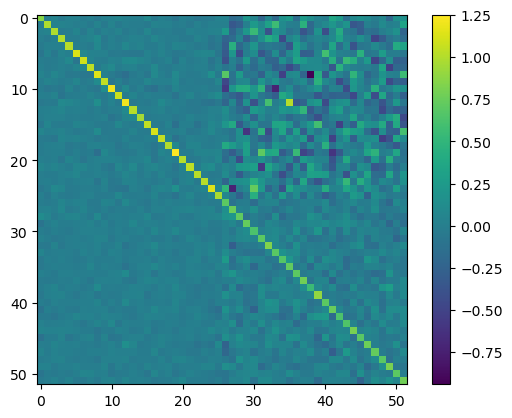

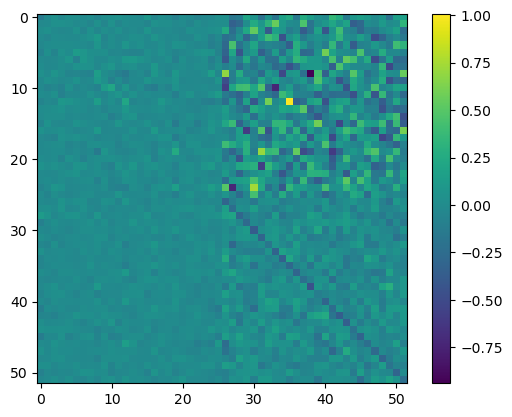

In [ ]:
plt.imshow(w)
plt.colorbar()
plt.show()
plt.imshow(w-np.eye(w.shape[0]))
plt.colorbar()
plt.show()

In [ ]:
w

array([[ 1.0207192 , -0.06690651, -0.03620916, ...,  0.10776399,
         0.04107473,  0.16639839],
       [-0.07819915,  1.1693089 ,  0.01765764, ...,  0.01682884,
         0.13645184, -0.04371026],
       [-0.03228309,  0.06292321,  1.0571172 , ..., -0.06564192,
        -0.13197425, -0.2602547 ],
       ...,
       [-0.0414278 , -0.12382236,  0.14927295, ...,  0.91699183,
         0.07981478, -0.0414281 ],
       [ 0.05126653, -0.22887959,  0.04595832, ..., -0.03034549,
         0.85497874, -0.04286855],
       [-0.07450514,  0.08732083,  0.1472544 , ..., -0.06801614,
        -0.01078751,  0.98007596]], dtype=float32)

In [ ]:
np.linalg.det(w)

0.1743148

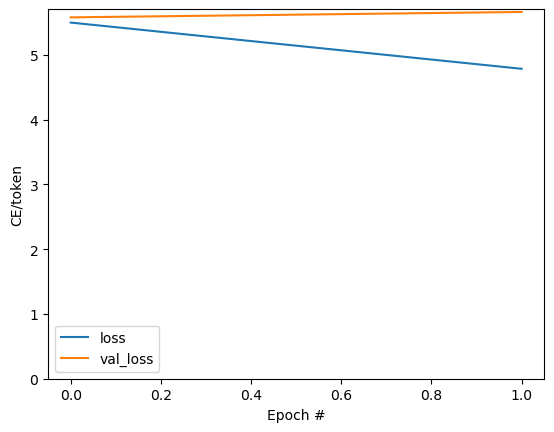

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

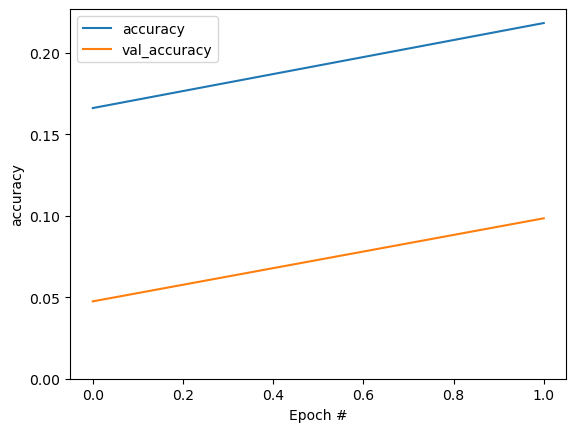

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
# result = model.translate(['¿Todavía está en casa?']) # Are you still home
# result[0].numpy().decode()

### Examples of translation

In [ ]:
text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10

for context_strings, target_strings in train_raw.take(1):
    for temp in np.arange(0.1, 0.7, 0.1):
        translate_strings = model.translate(context_strings, temperature=temp)

        encoded_strings = [x.numpy() for x in
                           [context_strings, translate_strings, target_strings]]
        print("Temperature is", np.round(temp, 2))
        for i in range(min(len(context_strings), n_samples)):
            for t in encoded_strings:
                print(t[i].decode())
            print()
            text_table.add_data(*[t[i].decode() for t in encoded_strings], temp)

wandb.log({"training_samples" : text_table})

tf.Tensor(
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]]

In [ ]:
# sentences from the paper

text_table = wandb.Table(columns=["source", "translate", "target", "temperature"])
n_samples = 10
context_strings = tf.constant([
    "Debemos limpiar la cocina.",
    "Admit que estaba equivocada.",
    "Cual es el lugar mas bonito del mundo?",
    "La caja es pesada.",
])
target_strings = tf.constant([
    "We must clean up the kitchen.",
    "I admitted that I was wrong.",
    "What's the most beautiful place in the world?",
    "The box is heavy.",
])
for temp in np.arange(0.1, 0.7, 0.1):
    translate_strings = model.translate(context_strings, temperature=temp)

    encoded_strings = [x.numpy() for x in
                        [context_strings, translate_strings, target_strings]]
    print("Temperature is", np.round(temp, 2))
    for i in range(min(len(context_strings), n_samples)):
        for t in encoded_strings:
            print(t[i].decode())
        print()
        text_table.add_data(*[t[i].decode() for t in encoded_strings], temp)

wandb.log({"paper_samples" : text_table})

tf.Tensor(
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]], shape=(4, 26, 26), dtype=float32)
tf.Tensor(
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. .

In [ ]:
wandb.finish()

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/det,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/masked_acc,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███████████████
batch/masked_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/max_grad,▁▂▄▅▄▄▄▅▆▅▄▅▆▇▄▅▆▅▅▅▄▅▆▄▄▃█▄▄▆▅▄▅▃▇▄▄▄▅▅
batch/mean_grad,▅▅▇▅▆▆▆▅▄▃▃▅▆▆▃▆▇▇▇▃▃▇▅▄▆▆▇▅▃▅▃▅▆▂██▃▆▁▄
batch/min_grad,█▇▅▅▆▆▄▆▄▅▅▆▄▃▅▄▄▄▅▄▃▅▄▆▆▆▅▅▆▄▅▅▃▅▃▅▅▆▄▁
batch/var_grad,▁▂▃▄▄▄▄▄▅▆▅▄▅▆▅▆▇▆▅▅▅▅▆▆▅▅▆▅▅▆▅▄▅▅█▅▅▅▆▆
epoch/det,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▅█
